In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import sympy as sp

## Recap from exp values (for us, not the students)

### 1. **First Neighbor Distance (Nearest Neighbor)**

This is the distance between a silicon atom and the four atoms to which it is **covalently bonded** in the diamond structure.

* **Lattice constant of Si**: \~5.431 Å
* The diamond structure has each atom tetrahedrally bonded to 4 neighbors.
* The **first neighbor distance** $d_1$ is:

  $$
  d_1 = \frac{\sqrt{3}}{4} \cdot a \approx \frac{1.732}{4} \cdot 5.431 \approx 2.35 \, \text{Å}
  $$

### 2. **Second Neighbor Distance (Next-Nearest Neighbor)**

This is the distance between a silicon atom and the 12 next-nearest atoms (not directly bonded but still in the crystal structure).

* The **second neighbor distance** $d_2$ is:

  $$
  d_2 = \frac{a}{\sqrt{2}} \approx \frac{5.431}{1.414} \approx 3.84 \, \text{Å}
  $$

## Force calculation
$$
\begin{align*}
- \nabla_{\mathbf{r}_i} v_2(r_{ij}) 
&= - \frac{\partial}{\partial \mathbf{r}_i} \left\{ \epsilon A \left( B r_{ij}^{-p} - r_{ij}^{-q} \right) \exp \left[ \left( r_{ij} - a \right)^{-1} \right] \right\} \\
&= - \epsilon A \frac{\mathbf{r}_{ij}}{r_{ij}} \left( \left[ \frac{\partial}{\partial r} \left( B r^{-p} - r^{-q} \right) \right] \bigg|_{r_{ij}} \exp \left[ \left( r_{ij} - a \right)^{-1} \right] \right. \\
&\quad + \left. \left( B r_{ij}^{-p} - r_{ij}^{-q} \right) \left\{ \frac{\partial}{\partial r} \exp \left[ (r - a)^{-1} \right] \right\} \bigg|_{r_{ij}} \right) \\
&= - \epsilon A \frac{\mathbf{r}_{ij}}{r_{ij}} \left\{ \left( -p B r_{ij}^{-p-1} + q r_{ij}^{-q-1} \right) \exp \left[ (r_{ij} - a)^{-1} \right] \right. \\
&\quad - \left. \left( B r_{ij}^{-p} - r_{ij}^{-q} \right) \exp \left[ (r_{ij} - a)^{-1} \right] (r_{ij} - a)^{-2} \right\} \\
&= v_2 \frac{\mathbf{r}_{ij}}{r_{ij}} \left[ \frac{p B r_{ij}^{-p-1} - q r_{ij}^{-q-1}}{B r_{ij}^{-p} - r_{ij}^{-q}} + (r_{ij} - a)^{-2} \right] \\
&\equiv \mathbf{f}_{ij}
\end{align*}
$$

In [2]:
# Define symbolic variable
r = sp.Symbol('r', real=True, positive=True)

# Parameters from the SW potential
A_val = 7.049556277
B_val = 0.6022245584
p_val = 4
q_val = 0
a_val = 1.8 

# Define the expression for the force scalar part
numerator = p_val * B_val * r**(-p_val - 1) - q_val * r**(-q_val - 1)
denominator = B_val * r**(-p_val) - r**(-q_val)
force_expr = (numerator / denominator + (r - a_val)**(-2))

# Solve for r where the force scalar is zero (i.e. equilibrium)
force_zero_roots = sp.solve(force_expr, r)

# Filter only real, positive roots
real_positive_roots = [sp.N(root) for root in force_zero_roots if root.is_real and root > 0]
real_positive_roots

[1.12246204829755]

In [3]:
sigma = 2.0951  # Angstroms
epsilon = 2.1682  # eV
A, B, p, q, a = 7.049556277, 0.6022245584, 4, 0, 1.8

# Define v2(r) in real units as a function
def v2_real_func(r):
    r_red = r / sigma
    if r >= a * sigma:
        return 0.0
    return epsilon * A * (B * r_red**(-p) - r_red**(-q)) * np.exp(1 / (r_red - a))

# Define numerical derivative: force = -dv2/dr
def force_real_func(r, h=1e-6):
    return -(v2_real_func(r + h) - v2_real_func(r - h)) / (2 * h)

# Use minimize_scalar on |force| to find the root of the force
force_root_result = minimize_scalar(lambda r: abs(force_real_func(r)),
                                    bounds=(2.0, a * sigma - 1e-4),
                                    method='bounded')

print(force_root_result.x if force_root_result.success else None)

2.3516714010669038


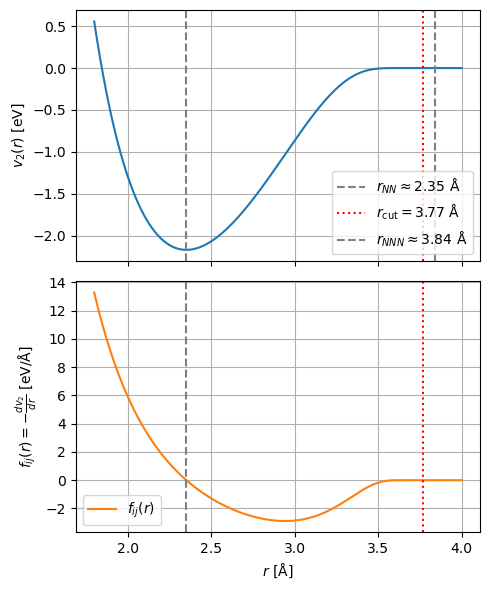

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6))

r_vals_real = np.linspace(1.8, 4, 500)
v2_vals = [v2_real_func(r) for r in r_vals_real]
force_vals = [force_real_func(r) for r in r_vals_real]


ax1.plot(r_vals_real, v2_vals, color='tab:blue')
ax1.axvline(x=2.35, color='gray', linestyle='--', label=r'$r_{NN} = 2.35\ \mathrm{\AA}$')
ax1.axvline(x=a * sigma, color='red', linestyle=':', label=fr'$r_{{\mathrm{{cut}}}} = {a * sigma:.2f}\ \mathrm{{\AA}}$')
ax1.axvline(x=3.84, color='gray', linestyle='--', label=r'$r_{NNN} = 3.84\ \mathrm{\AA}$')
ax1.set_ylabel(r'$v_2(r)\ \mathrm{[eV]}$')

ax1.grid(True)
ax1.legend()

# Plot force with LaTeX labels
ax2.plot(r_vals_real, force_vals, color='tab:orange', label=r'$f_{ij}(r)$')
ax2.axvline(x=2.35, color='gray', linestyle='--')
ax2.axvline(x=a * sigma, color='red', linestyle=':')
ax2.set_xlabel(r'$r\ \mathrm{[\AA]}$')
ax2.set_ylabel(r'$f_{ij}(r) = -\frac{dv_2}{dr}\ \mathrm{[eV/\AA]}$')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

## Pretend you don't know anything: calculate lattice constant

Silicon crystallizes in a **diamond cubic** structure, which is a face-centered cubic (FCC) lattice with a 2-atom basis.

* In this structure, the **nearest-neighbor atoms** are along the body diagonals.
* The **NN distance** corresponds to:

  $$
  r_{\text{NN}} = \frac{\sqrt{3}}{4} a
  $$

  where $a$ is the **lattice constant**.


Solve for $a$:

$$
a = \frac{4}{\sqrt{3}} r_{\text{NN}}
$$

$$
r_{\text{NN}} = 2.3516714010669038\ \text{Å}
$$

So the lattice constant becomes:

$$
a = \frac{4}{\sqrt{3}} \cdot 2.3517
$$

Let’s compute it.


The **lattice constant** of silicon corresponding to the nearest-neighbor distance $r_{\text{NN}} = 2.3517$ Å is:

$$
\boxed{a \approx 5.431\ \mathrm{\AA}}
$$

## Calculate energy per atom

Energy per atom using $v_2(r)$

We'll compute the **energy per atom** by summing up the pairwise potential contributions from **all neighbors**, using the fact that:

$$
E_{\text{atom}} = \frac{1}{2} \sum_j v_2(r_{ij})
$$

The factor of ½ avoids double-counting since each interaction is shared between two atoms.

---

## 1: Use known equilibrium distance

From earlier:

* Nearest-neighbor distance: $r_{ij} = r_{\text{NN}} = 2.3517\ \text{Å}$

---

## 2: Count neighbors in diamond cubic

In the **diamond cubic** structure, each atom has:

* **4 first-nearest neighbors**
* **12 second-nearest neighbors**
* **12 third-nearest neighbors**
* and so on...

But:

* The **cutoff** of the SW potential is $r_{\text{cut}} = 1.8\,\sigma = 3.7712\ \text{Å}$
* So only **1st and 2nd neighbor shells** may contribute.

Let’s check:

In the **diamond cubic structure**, the 2nd neighbors are:

* Distance:

  $$
  r_{\text{2nd}} = \frac{a}{\sqrt{2}} \approx \frac{5.43}{1.414} \approx 3.84\ \text{Å}
  $$
* Number:

  $$
  \text{12 second-nearest neighbors}
  $$

So:

* 1st NN: 4 neighbors at $r_1 = 2.3517$ Å $\implies$ included
* 2nd NN: 12 neighbors at $r_2 = \frac{a}{\sqrt{2}} \approx 3.84$ Å $\implies$ outside cutoff



## 3: Compute energy

We just evaluate:

$$
E_{\text{atom}} = \frac{1}{2} \sum_{j=1}^{4} v_2(r_{ij}) = 2 \cdot v_2(r_{\text{NN}})
$$

Let me compute this next.


The **two-body energy per atom** in the diamond structure of silicon, using the Stillinger–Weber potential and including only first-neighbor interactions, is:

$$
\boxed{E_{\text{atom}}^{(2)} \approx -4.34\ \mathrm{eV}}
$$

This is quite close to the known cohesive energy of silicon (\~4.63 eV/atom), especially considering we only included the two-body term and just the 4 nearest neighbors.

## Include 2nd neighbors in the cutoff


$$
r_{\text{cut}} > r_{\text{2nd}} = 3.84\ \text{Å}
$$

That is, set a new $a' > \frac{r_{\text{2nd}}}{\sigma} = \frac{3.84}{2.0951} \approx 1.8$



### How does the curve change?

The pair potential $v_2(r)$ includes a **cutoff function** via the exponential:

$$
v_2(r) = \epsilon A \left( B r^{-p} - r^{-q} \right) \exp\left[\frac{1}{r/\sigma - a} \right]
\quad \text{for } r/\sigma < a
$$

* Increasing $a$ makes the **exponential decay slower**, thus:

  * **Flattens the tail**
  * Allows weak interactions from further neighbors (like 2nd shell)
* But also changes the **shape and curvature** of the potential well slightly

So the curve becomes:

* **Broader**
* **Less steep near the cutoff**
* With **nonzero tail** reaching 3.84 Å

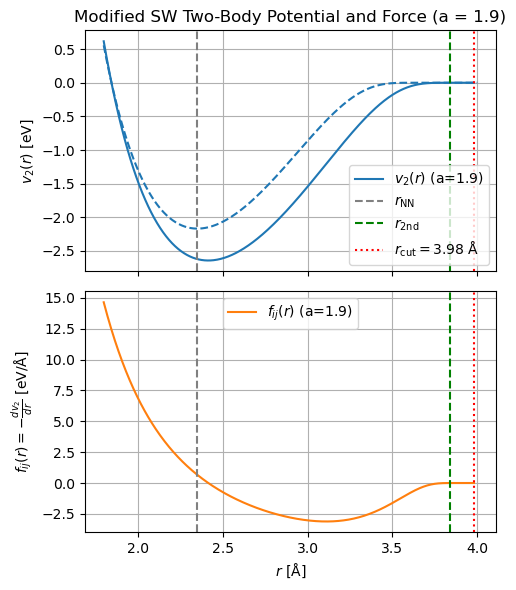

-5.24292122889725


In [9]:
# Redefine constants
sigma = 2.0951  # Angstroms
epsilon = 2.1682  # eV
A = 7.049556277
B = 0.6022245584
p = 4
q = 0
a_modified = 1.9  # new cutoff value

# Define the potential function with modified cutoff
def v2_modified(r):
    r_red = r / sigma
    if r >= a_modified * sigma:
        return 0.0
    return epsilon * A * (B * r_red**(-p) - r_red**(-q)) * np.exp(1 / (r_red - a_modified))

# Define numerical derivative for force
def force_modified(r, h=1e-6):
    return -(v2_modified(r + h) - v2_modified(r - h)) / (2 * h)

# Prepare data for plotting
r_vals_mod = np.linspace(1.8, a_modified * sigma - 1e-4, 500)
v2_vals_mod = [v2_modified(r) for r in r_vals_mod]
force_vals_mod = [force_modified(r) for r in r_vals_mod]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6))

# Plot potential
ax1.plot(r_vals_real, v2_vals, '--')
ax1.plot(r_vals_mod, v2_vals_mod, color='tab:blue', label=r'$v_2(r)$ (a=1.9)')
ax1.axvline(x=2.3517, color='gray', linestyle='--', label=r'$r_{\mathrm{NN}}$')
ax1.axvline(x=3.84, color='green', linestyle='--', label=r'$r_{\mathrm{2nd}}$')
ax1.axvline(x=a_modified * sigma, color='red', linestyle=':', label=fr'$r_{{\mathrm{{cut}}}} = {a_modified * sigma:.2f}\ \mathrm{{\AA}}$')
ax1.set_ylabel(r'$v_2(r)\ \mathrm{[eV]}$')
ax1.set_title('Modified SW Two-Body Potential and Force (a = 1.9)')
ax1.grid(True)
ax1.legend()

# Plot force
ax2.plot(r_vals_mod, force_vals_mod, color='tab:orange', label=r'$f_{ij}(r)$ (a=1.9)')
ax2.axvline(x=2.3517, color='gray', linestyle='--')
ax2.axvline(x=3.84, color='green', linestyle='--')
ax2.axvline(x=a_modified * sigma, color='red', linestyle=':')
ax2.set_xlabel(r'$r\ \mathrm{[\AA]}$')
ax2.set_ylabel(r'$f_{ij}(r) = -\frac{dv_2}{dr}\ \mathrm{[eV/\AA]}$')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Energy per atom: 4 1st neighbors + 12 2nd neighbors
v2_1st = v2_modified(2.3517)
v2_2nd = v2_modified(3.84)
energy_per_atom_extended = 0.5 * (4 * v2_1st + 12 * v2_2nd)
print(energy_per_atom_extended)